In [1]:
%load_ext cudf.pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# TODO - test inside of Kaggle container: https://github.com/kaggle/docker-python
import numpy as np
import pandas as pd

In [4]:
# https://www.kaggle.com/competitions/optiver-trading-at-the-close/data
raw = pd.read_csv('./.data/train.csv')
raw.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [5]:
for col in raw.columns:
    ratio = (raw[col].isnull().sum() / len(raw)) * 100
    print(f'Null ratio: {ratio:06.3f}% - Column: {col}')

Null ratio: 00.000% - Column: stock_id
Null ratio: 00.000% - Column: date_id
Null ratio: 00.000% - Column: seconds_in_bucket
Null ratio: 00.004% - Column: imbalance_size
Null ratio: 00.000% - Column: imbalance_buy_sell_flag
Null ratio: 00.004% - Column: reference_price
Null ratio: 00.004% - Column: matched_size
Null ratio: 55.257% - Column: far_price
Null ratio: 54.547% - Column: near_price
Null ratio: 00.004% - Column: bid_price
Null ratio: 00.000% - Column: bid_size
Null ratio: 00.004% - Column: ask_price
Null ratio: 00.000% - Column: ask_size
Null ratio: 00.004% - Column: wap
Null ratio: 00.002% - Column: target
Null ratio: 00.000% - Column: time_id
Null ratio: 00.000% - Column: row_id


In [6]:
raw.far_price.describe()

count    2.343638e+06
mean     1.001713e+00
std      7.214710e-01
min      7.700000e-05
25%      9.963320e-01
50%      9.998830e-01
75%      1.003318e+00
max      4.379531e+02
Name: far_price, dtype: float64

In [7]:
raw.near_price.describe()

count    2.380800e+06
mean     9.996600e-01
std      1.216900e-02
min      7.869880e-01
25%      9.971000e-01
50%      9.998890e-01
75%      1.002590e+00
max      1.309732e+00
Name: near_price, dtype: float64

In [8]:
raw.tail()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198
5237979,199,480,540,1884285.71,-1,1.002129,24073677.32,1.000859,1.001494,1.002129,250081.44,1.002447,300167.56,1.002274,-6.530285,26454,480_540_199


`far_price` and `near_price` are only available at EOD when the auction is live, but is NaN otherwise. I don't want to drop these columns, but I also want to use a regression which means imputing isn't an option. I think the path forward is to use only the auction rows as inputs, and add the null rows as a lag features for those rows.

In [9]:
raw[(raw.stock_id == 0) & (raw.date_id == 0)]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0
955,0,0,50,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000348,42012.00,1.000455,9897.22,1.000434,0.599623,5,0_50_0
1146,0,0,60,1218204.43,1,1.000562,15342674.90,NaN,NaN,1.000455,14005.50,1.000562,10085.04,1.000517,-0.200272,6,0_60_0
1337,0,0,70,1264494.89,1,1.000455,15352380.96,NaN,NaN,1.000348,37904.16,1.000455,17366.82,1.000421,2.410412,7,0_70_0
1528,0,0,80,1189832.86,1,1.000241,15427043.00,NaN,NaN,1.000133,9427.34,1.000241,61984.40,1.000148,-0.389814,8,0_80_0
1719,0,0,90,1189272.89,1,1.000562,15427602.97,NaN,NaN,1.000348,23340.00,1.000562,40433.54,1.000426,-4.339814,9,0_90_0


In [10]:
raw[(raw.stock_id == 0) & (raw.date_id == 480)]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5226980,0,480,0,5372506.50,1,0.999894,18358363.51,NaN,NaN,0.999894,18186.19,1.000070,11974.20,1.000000,-1.279712,26400,480_0_0
5227180,0,480,10,5315490.47,1,1.000245,18377463.88,NaN,NaN,1.000070,45673.02,1.000245,2851.50,1.000235,0.840426,26401,480_10_0
5227380,0,480,20,5383909.70,1,1.000070,18377463.88,NaN,NaN,0.999894,101819.86,1.000070,1938.68,1.000066,5.990267,26402,480_20_0
5227580,0,480,30,5372506.50,1,1.000070,18388867.09,NaN,NaN,0.999894,35745.27,1.000070,54910.26,0.999963,4.980564,26403,480_30_0
5227780,0,480,40,5327463.83,1,1.000070,18433909.75,NaN,NaN,0.999894,46406.14,1.000070,28510.00,1.000003,-2.440214,26404,480_40_0
5227980,0,480,50,5297587.43,1,1.000070,18463786.15,NaN,NaN,0.999894,35175.17,1.000070,33641.80,0.999984,-2.599955,26405,480_50_0
5228180,0,480,60,5297587.43,1,1.000070,18463786.15,NaN,NaN,0.999894,53133.32,1.000070,48409.98,0.999986,-1.270175,26406,480_60_0
5228380,0,480,70,5229168.20,1,1.000420,18463786.15,NaN,NaN,1.000245,92616.72,1.000420,19678.80,1.000390,-6.200075,26407,480_70_0
5228580,0,480,80,5229168.20,1,1.000596,18463786.15,NaN,NaN,1.000420,63770.72,1.000596,31548.65,1.000538,-10.420084,26408,480_80_0
5228780,0,480,90,5156928.89,1,1.000420,18536025.46,NaN,NaN,1.000245,22526.85,1.000420,53503.52,1.000297,-7.339716,26409,480_90_0


For the NaN rows, I'll train a linear regression to backfill them based on the post-3:55 data.

In [11]:
from sklearn.linear_model import LinearRegression

def regression_imputer(data:pd.DataFrame, target_col:str, drop_cols=[]) -> pd.DataFrame:
    X_train = data[data[target_col].notna()].drop(drop_cols, axis=1)
    y_train = data[target_col].loc[data.index.isin(X_train.index)]
    model = LinearRegression().fit(X_train, y_train)
    X_test = data[data[target_col].isna()].drop(drop_cols, axis=1).dropna()
    y_test = model.predict(X_test)
    return pd.DataFrame(y_test, columns=[target_col], index=X_test.index)

In [12]:
far_price_imputed = regression_imputer(raw, 'far_price', drop_cols=['far_price', 'near_price', 'target'])
far_price_imputed.describe()

,far_price
count,2.894122e+06
mean,1.004164e+00
std,1.534800e-02
min,9.021560e-01
25%,9.903750e-01
50%,1.003975e+00
75%,1.017186e+00
max,1.442519e+00


In [13]:
raw.far_price.describe()

count    2.343638e+06
mean     1.001713e+00
std      7.214710e-01
min      7.700000e-05
25%      9.963320e-01
50%      9.998830e-01
75%      1.003318e+00
max      4.379531e+02
Name: far_price, dtype: float64

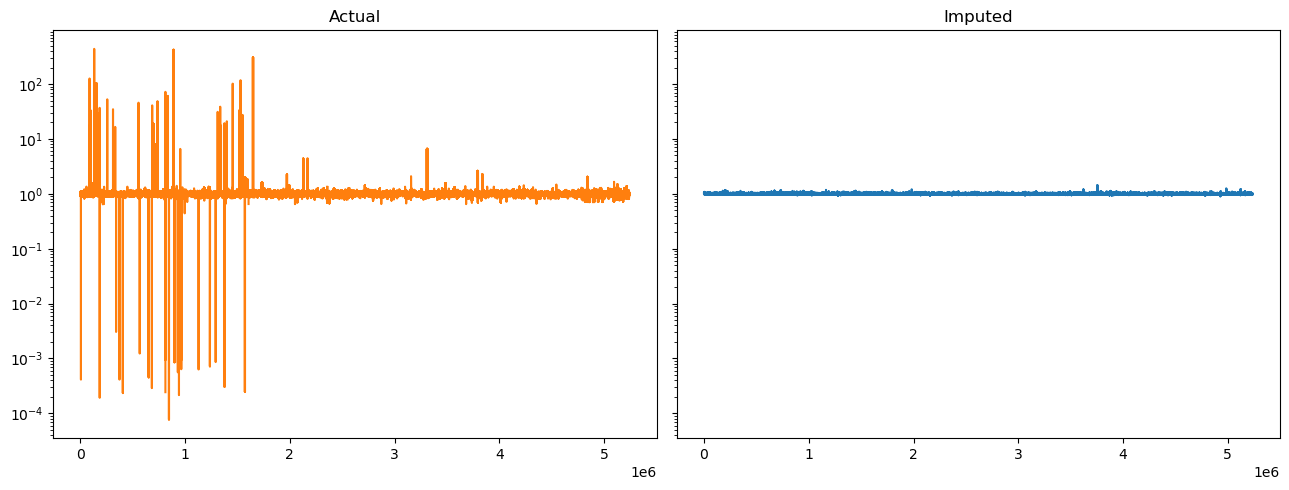

In [14]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(13, 5), autolayout=True)

_, axs = plt.subplots(1, 2, sharey=True)
ax = raw.far_price.plot(ax=axs[0], title='Actual', color='C1')
ax = far_price_imputed.plot(ax=axs[1], title='Imputed', legend=False)
ax.set_yscale('log')
pass

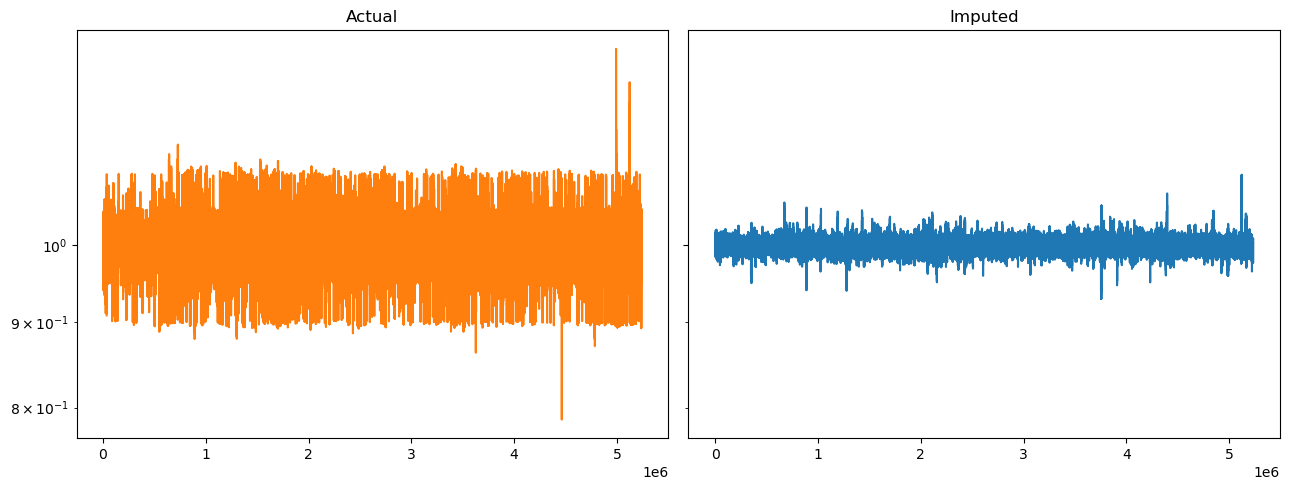

In [15]:
near_price_imputed = regression_imputer(raw, 'near_price', drop_cols=['far_price', 'near_price', 'target'])
_, axs = plt.subplots(1, 2, sharey=True)
ax = raw.near_price.plot(ax=axs[0], title='Actual', color='C1')
ax = near_price_imputed.plot(ax=axs[1], title='Imputed', legend=False)
ax.set_yscale('log')
pass

In [16]:
imputed = raw.copy()
imputed.fillna(far_price_imputed, inplace=True)
imputed.fillna(near_price_imputed, inplace=True)
imputed

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,1.023970,1.005219,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.996186,0.992556,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.997297,0.992393,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999665,0.992156,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.997063,0.992308,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [17]:
imputed.dropna()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,1.023970,1.005219,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.996186,0.992556,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.997297,0.992393,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999665,0.992156,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.997063,0.992308,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [18]:
# some rows are still missing, but at this point I'll interpolate the rest
imputed.interpolate(inplace=True)
imputed.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715229e+06,-1.189600e-02,9.999960e-01,4.509903e+07,1.003067e+00,9.992450e-01,9.997260e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756100e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051549e+07,8.853370e-01,2.532000e-03,1.398385e+08,4.827300e-01,9.633000e-03,2.499000e-03,1.114214e+05,2.510000e-03,1.293554e+05,2.497000e-03,9.452797e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.456663e+04,-1.000000e+00,9.987630e-01,5.279831e+06,9.927270e-01,9.938890e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113684e+06,0.000000e+00,9.999670e-01,1.288295e+07,1.000440e+00,9.996280e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020100e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.191219e+06,1.000000e+00,1.001174e+00,3.269849e+07,1.013020e+00,1.004309e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [19]:
raw.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189600e-02,9.999960e-01,4.510025e+07,1.001713e+00,9.996600e-01,9.997260e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756100e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853370e-01,2.532000e-03,1.398413e+08,7.214710e-01,1.216900e-02,2.499000e-03,1.114214e+05,2.510000e-03,1.293554e+05,2.498000e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020100e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [20]:
len(imputed)

5237980

In [21]:
# now to shape lag features. I'll do a 60 second lookback
# <date_id>_<seconds_in_bucket>_<stock_id>

def create_lags(data:pd.DataFrame) -> pd.DataFrame:
    lagged_rows = []
    # lagged_data = data.copy()
    for i, row in data.iterrows():
        date = row.date_id
        seconds = row.seconds_in_bucket
        stock = row.stock_id
        seconds -= 60
        if seconds < 0:
        #     seconds = 540
        #     date -= 1
        # if date < 0:
            continue
        lag_row = pd.DataFrame(data[data.row_id == f'{date}_{seconds}_{stock}'])
        lag_row.columns = [f'prev_{col}' for col in lag_row.columns]
        lag_row.index = [i]
        # lagged_data = pd.concat([lagged_data, lag_row], axis=1)
        # return lagged_data
        lagged_rows.append(lag_row)
        if len(lagged_rows) > 0:
            print(lagged_rows)
            break
    # return pd.DataFrame(lagged_rows)

create_lags(imputed)

[      prev_stock_id  prev_date_id  prev_seconds_in_bucket  \
1146              0             0                       0   

      prev_imbalance_size  prev_imbalance_buy_sell_flag  prev_reference_price  \
1146           3180602.69                             1              0.999812   

      prev_matched_size  prev_far_price  prev_near_price  prev_bid_price  \
1146        13380276.64         1.02397         1.005219        0.999812   

      prev_bid_size  prev_ask_price  prev_ask_size  prev_wap  prev_target  \
1146        60651.5        1.000026        8493.03       1.0    -3.029704   

      prev_time_id prev_row_id  
1146             0       0_0_0  ]


In [22]:
imputed.loc[1146]

stock_id                            0
date_id                             0
seconds_in_bucket                  60
imbalance_size             1218204.43
imbalance_buy_sell_flag             1
reference_price              1.000562
matched_size               15342674.9
far_price                     1.02485
near_price                   1.006145
bid_price                    1.000455
bid_size                      14005.5
ask_price                    1.000562
ask_size                     10085.04
wap                          1.000517
target                      -0.200272
time_id                             6
row_id                         0_60_0
Name: 1146, dtype: object

The issue I'm having right now is that it's taking way too long to go through each row because I'm trying to look up the previous row for each `stock_id`. I think where I messed up is not sorting these out in the beginning, so let's start over with the `raw_data`.

In [23]:
sorted = raw.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).sort_index()
sorted

imbalance_size  imbalance_buy_sell_flag  \
stock_id date_id seconds_in_bucket                                            
0        0       0                      3180602.69                        1   
                 10                     1299772.70                        1   
                 20                     1299772.70                        1   
                 30                     1299772.70                        1   
                 40                     1218204.43                        1   
...                                            ...                      ...   
199      480     500                    2661783.46                       -1   
                 510                    2658917.61                       -1   
                 520                    1352558.88                       -1   
                 530                    1352558.88                       -1   
                 540                    1884285.71                       -1   

                                    reference_price  matched_size far_price  \
stock_id date_id seconds_in_bucket                                            
0        0       0                         0.999812   13380276.64      <NA>   
                 10                        1.000026   15261106.63      <NA>   
                 20                        0.999919   15261106.63      <NA>   
                 30                        1.000133   15261106.63      <NA>   
                 40                        1.000455   15342674.90      <NA>   
...                                             ...           ...       ...   
199      480     500                       1.002764   23969215.23  1.000859   
                 510                       1.002764   23972081.09  1.000859   
                 520                       1.001812   23978379.68  1.000859   
                 530                       1.001812   23978379.68  1.000859   
                 540                       1.002129   24073677.32  1.000859   

                                   near_price  bid_price   bid_size  \
stock_id date_id seconds_in_bucket                                    
0        0       0                       <NA>   0.999812   60651.50   
                 10                      <NA>   0.999812   13996.50   
                 20                      <NA>   0.999812    4665.50   
                 30                      <NA>   1.000026   55998.00   
                 40                      <NA>   1.000241   14655.95   
...                                       ...        ...        ...   
199      480     500                 1.001494   1.002764  122246.18   
                 510                 1.001494   1.002764  677012.04   
                 520                 1.001494   1.001812  225361.65   
                 530                 1.001494   1.001812  285559.05   
                 540                 1.001494   1.002129  250081.44   

                                    ask_price   ask_size       wap    target  \
stock_id date_id seconds_in_bucket                                             
0        0       0                   1.000026    8493.03  1.000000 -3.029704   
                 10                  1.000026   23519.16  0.999892  0.389814   
                 20                  0.999919   12131.60  0.999842  4.220009   
                 30                  1.000133   46203.30  1.000085  5.450249   
                 40                  1.000455   26610.45  1.000317  3.169775   
...                                       ...        ...       ...       ...   
199      480     500                 1.003082  425296.17  1.002835 -7.209778   
                 510                 1.003082  347268.87  1.002974 -9.750128   
                 520                 1.002129  194630.52  1.001982  3.629923   
                 530                 1.002129  214513.32  1.001993  4.760027   
                 540                 1.002447  300167.56  1.002274 -6.530285   

               

In [24]:
sorted.shift(1).loc[1]

imbalance_size  imbalance_buy_sell_flag  \
date_id seconds_in_bucket                                            
0       0                       475513.69                       -1   
        10                      166603.91                       -1   
        20                      165923.20                       -1   
        30                      165923.20                       -1   
        40                      165923.20                       -1   
...                                   ...                      ...   
480     500                     133272.15                       -1   
        510                      88468.41                       -1   
        520                     310778.50                       -1   
        530                     310778.50                       -1   
        540                     310778.50                       -1   

                           reference_price  matched_size  far_price  \
date_id seconds_in_bucket                                             
0       0                         0.999193   41686415.27   0.999017   
        10                        0.999896    1642214.25        NaN   
        20                        0.999955    1642894.96        NaN   
        30                        0.999955    1642894.96        NaN   
        40                        0.999896    1642894.96        NaN   
...                                    ...           ...        ...   
480     500                       0.996701    7591006.85   0.996121   
        510                       0.996648    7635810.59   0.996121   
        520                       0.996806    7413500.50   0.996121   
        530                       0.996806    7413500.50   0.996121   
        540                       0.996806    7413500.50   0.996121   

                           near_price  bid_price   bid_size  ask_price  \
date_id seconds_in_bucket                                                
0       0                    0.999017   0.999193  110123.01   0.999368   
        10                        NaN   0.999896    3233.04   1.000660   
        20                        NaN   0.999896    3743.52   1.000660   
        30                        NaN   0.999896    3743.52   1.000660   
        40                        NaN   0.999896    4254.00   1.000308   
...                               ...        ...        ...        ...   
480     500                  0.996437   0.996437   95341.68   0.997175   
        510                  0.996437   0.996437  176306.44   0.996859   
        520                  0.996543   0.996543    1324.33   0.997122   
        530                  0.996490   0.996543    3783.80   0.997122   
        540                  0.996490   0.996543    7567.60   0.997122   

                            ask_size       wap     target  time_id     row_id  
date_id seconds_in_bucket                                                      
0       0                  283817.38  0.999242   0.760555    26454  480_540_0  
        10                  20605.09  1.000000  -5.519986        0      0_0_1  
        20                  33717.42  0.999973  -1.620054        1     0_10_1  
        30                  33717.42  0.999973  -6.459951        2     0_20_1  
        40                   3574.83  1.000120  -5.149841        3     0_30_1  
...                              ...       ...        ...      ...        ...  
480     500                 22717.20  0.997033   0.560284    26449  480_490_1  
        510                 64345.00  0.996746   2.850294    26450  480_500_1  
        520                 47135.70  0.996559   3.169775    26451  480_510_1  
        530                 85374.30  0.996567   5.689859    26452  480_520_1  
        540                112065.60  0.996579  10.650158    26453  480_530_1  

[26455 rows x 14 columns]

In [25]:
sorted.loc[1].shift(1)

imbalance_size imbalance_buy_sell_flag  \
date_id seconds_in_bucket                                          
0       0                           <NA>                    <NA>   
        10                     166603.91                      -1   
        20                      165923.2                      -1   
        30                      165923.2                      -1   
        40                      165923.2                      -1   
...                                  ...                     ...   
480     500                    133272.15                      -1   
        510                     88468.41                      -1   
        520                     310778.5                      -1   
        530                     310778.5                      -1   
        540                     310778.5                      -1   

                          reference_price matched_size far_price near_price  \
date_id seconds_in_bucket                                                     
0       0                            <NA>         <NA>      <NA>       <NA>   
        10                       0.999896   1642214.25       NaN        NaN   
        20                       0.999955   1642894.96       NaN        NaN   
        30                       0.999955   1642894.96       NaN        NaN   
        40                       0.999896   1642894.96       NaN        NaN   
...                                   ...          ...       ...        ...   
480     500                      0.996701   7591006.85  0.996121   0.996437   
        510                      0.996648   7635810.59  0.996121   0.996437   
        520                      0.996806    7413500.5  0.996121   0.996543   
        530                      0.996806    7413500.5  0.996121    0.99649   
        540                      0.996806    7413500.5  0.996121    0.99649   

                          bid_price   bid_size ask_price  ask_size       wap  \
date_id seconds_in_bucket                                                      
0       0                      <NA>       <NA>      <NA>      <NA>      <NA>   
        10                 0.999896    3233.04   1.00066  20605.09       1.0   
        20                 0.999896    3743.52   1.00066  33717.42  0.999973   
        30                 0.999896    3743.52   1.00066  33717.42  0.999973   
        40                 0.999896     4254.0  1.000308   3574.83   1.00012   
...                             ...        ...       ...       ...       ...   
480     500                0.996437   95341.68  0.997175   22717.2  0.997033   
        510                0.996437  176306.44  0.996859   64345.0  0.996746   
        520                0.996543    1324.33  0.997122   47135.7  0.996559   
        530                0.996543     3783.8  0.997122   85374.3  0.996567   
        540                0.996543     7567.6  0.997122  112065.6  0.996579   

                               target time_id     row_id  
date_id seconds_in_bucket                                 
0       0                        <NA>    <NA>       <NA>  
        10                  -5.519986       0      0_0_1  
        20                 -1.6200542       1     0_10_1  
        30                 -6.4599514       2     0_20_1  
        40                 -5.1498413       3     0_30_1  
...                               ...     ...        ...  
480     500                0.56028366   26449  480_490_1  
        510                  2.850294   26450  480_500_1  
        520                  3.169775   26451  480_510_1  
        530                 5.6898594   26452  480_520_1  
        540                 10.650158   26453  480_530_1  

[26455 rows x 14 columns]

In [26]:
sorted.groupby(level=0).shift(1).loc[1]

imbalance_size  imbalance_buy_sell_flag  \
date_id seconds_in_bucket                                            
0       0                             NaN                      NaN   
        10                      166603.91                     -1.0   
        20                      165923.20                     -1.0   
        30                      165923.20                     -1.0   
        40                      165923.20                     -1.0   
...                                   ...                      ...   
480     500                     133272.15                     -1.0   
        510                      88468.41                     -1.0   
        520                     310778.50                     -1.0   
        530                     310778.50                     -1.0   
        540                     310778.50                     -1.0   

                           reference_price  matched_size  far_price  \
date_id seconds_in_bucket                                             
0       0                              NaN           NaN        NaN   
        10                        0.999896    1642214.25        NaN   
        20                        0.999955    1642894.96        NaN   
        30                        0.999955    1642894.96        NaN   
        40                        0.999896    1642894.96        NaN   
...                                    ...           ...        ...   
480     500                       0.996701    7591006.85   0.996121   
        510                       0.996648    7635810.59   0.996121   
        520                       0.996806    7413500.50   0.996121   
        530                       0.996806    7413500.50   0.996121   
        540                       0.996806    7413500.50   0.996121   

                           near_price  bid_price   bid_size  ask_price  \
date_id seconds_in_bucket                                                
0       0                         NaN        NaN        NaN        NaN   
        10                        NaN   0.999896    3233.04   1.000660   
        20                        NaN   0.999896    3743.52   1.000660   
        30                        NaN   0.999896    3743.52   1.000660   
        40                        NaN   0.999896    4254.00   1.000308   
...                               ...        ...        ...        ...   
480     500                  0.996437   0.996437   95341.68   0.997175   
        510                  0.996437   0.996437  176306.44   0.996859   
        520                  0.996543   0.996543    1324.33   0.997122   
        530                  0.996490   0.996543    3783.80   0.997122   
        540                  0.996490   0.996543    7567.60   0.997122   

                            ask_size       wap     target  time_id     row_id  
date_id seconds_in_bucket                                                      
0       0                        NaN       NaN        NaN      NaN       <NA>  
        10                  20605.09  1.000000  -5.519986      0.0      0_0_1  
        20                  33717.42  0.999973  -1.620054      1.0     0_10_1  
        30                  33717.42  0.999973  -6.459951      2.0     0_20_1  
        40                   3574.83  1.000120  -5.149841      3.0     0_30_1  
...                              ...       ...        ...      ...        ...  
480     500                 22717.20  0.997033   0.560284  26449.0  480_490_1  
        510                 64345.00  0.996746   2.850294  26450.0  480_500_1  
        520                 47135.70  0.996559   3.169775  26451.0  480_510_1  
        530                 85374.30  0.996567   5.689859  26452.0  480_520_1  
        540                112065.60  0.996579  10.650158  26453.0  480_530_1  

[26455 rows x 14 columns]

That didn't take long at all. Let's preprocess again.

This time I'm going to loop through the `stock_id` (0-199) and process each stock individually.

In [47]:
stocks = []
for stock_id in range(200):
    print(f'Preprocessing {stock_id / 2:04.1f}% Complete', end='\r')

    stock = pd.DataFrame(sorted.loc[stock_id])
    for crossing_price in ['far_price', 'near_price']: # impute
        price_imp = regression_imputer(stock, crossing_price, drop_cols=['far_price', 'near_price', 'target'])
        stock.fillna(price_imp, inplace=True)
    stock.interpolate(inplace=True)
    
    lags = [] # lag features
    temp = stock.drop(['time_id', 'row_id', 'target'], axis=1)
    for i in range(1, 7): # lag by 60s (6 period lookback)
        lag = temp.shift(i)
        lag.columns = [f'{col}_lag_{i}0s' for col in lag.columns]
        lags.append(lag)
    stock = stock.join(lags, how='inner').dropna(axis=0)
    
    stock['stock_id'] = stock_id
    stocks.append(stock)
print('Preprocessing 100.0% Complete')

Preprocessing 100.0% Complete


In [48]:
stocks[0]

imbalance_size  imbalance_buy_sell_flag  \
date_id seconds_in_bucket                                            
0       60                     1218204.43                        1   
        70                     1264494.89                        1   
        80                     1189832.86                        1   
        90                     1189272.89                        1   
        100                    1249282.50                        1   
...                                   ...                      ...   
480     500                          0.00                        0   
        510                          0.00                        0   
        520                     475513.69                       -1   
        530                     475513.69                       -1   
        540                     475513.69                       -1   

                           reference_price  matched_size  far_price  \
date_id seconds_in_bucket                                             
0       60                        1.000562   15342674.90   1.004668   
        70                        1.000455   15352380.96   1.004777   
        80                        1.000241   15427043.00   1.004103   
        90                        1.000562   15427602.97   1.003756   
        100                       1.000348   15427602.97   1.004395   
...                                    ...           ...        ...   
480     500                       0.999017   42161928.97   0.999017   
        510                       0.998842   42161928.97   0.998842   
        520                       0.999193   41686415.27   0.999017   
        530                       0.999193   41686415.27   0.999017   
        540                       0.999193   41686415.27   0.999017   

                           near_price  bid_price   bid_size  ask_price  \
date_id seconds_in_bucket                                                
0       60                   1.002605   1.000455   14005.50   1.000562   
        70                   1.002638   1.000348   37904.16   1.000455   
        80                   1.001980   1.000133    9427.34   1.000241   
        90                   1.002206   1.000348   23340.00   1.000562   
        100                  1.002260   1.000241    9801.75   1.000348   
...                               ...        ...        ...        ...   
480     500                  0.999017   0.999017   53827.20   0.999193   
        510                  0.998842   0.998842  157865.40   0.999017   
        520                  0.999017   0.999193   57596.67   0.999368   
        530                  0.999017   0.999193  156610.53   0.999368   
        540                  0.999017   0.999193  110123.01   0.999368   

                            ask_size  ...  reference_price_lag_6  \
date_id seconds_in_bucket             ...                          
0       60                  10085.04  ...               0.999812   
        70                  17366.82  ...               1.000026   
        80                  61984.40  ...               0.999919   
        90                  40433.54  ...               1.000133   
        100                 42572.16  ...               1.000455   
...                              ...  ...                    ...   
480     500                146071.08  ...               0.998667   
        510                120926.08  ...               0.998842   
        520                 46780.58  ...               0.999368   
        530                122677.94  ...               0.999193   
        540                283817.38  ...               0.999193   

                           matched_size_lag_6  far_price_lag_6  \
date_id seconds_in_bucket                                        
0       60                        13380276.64         1.002015   
        70                        15261106.63         1.001522   
        80                        15261106.63         1.002407   
        90    

In [49]:
stocks[151]

imbalance_size  imbalance_buy_sell_flag  \
date_id seconds_in_bucket                                            
0       60                    20426441.37                        1   
        70                    20354487.22                        1   
        80                    20365574.15                        1   
        90                    20404378.39                        1   
        100                   20746299.19                        1   
...                                   ...                      ...   
480     500                    4085845.34                        1   
        510                    2317403.49                        1   
        520                    2291517.33                        1   
        530                    2291517.33                        1   
        540                    2291517.33                        1   

                           reference_price  matched_size  far_price  \
date_id seconds_in_bucket                                             
0       60                        1.000638  5.490379e+07   1.003199   
        70                        1.000818  5.503118e+07   1.003623   
        80                        1.000818  5.503118e+07   1.003655   
        90                        1.000818  5.503118e+07   1.003803   
        100                       1.000818  5.503472e+07   1.003812   
...                                    ...           ...        ...   
480     500                       1.001097  1.203359e+08   1.001680   
        510                       1.001291  1.221043e+08   1.001680   
        520                       1.001291  1.221302e+08   1.001680   
        530                       1.001291  1.221302e+08   1.001680   
        540                       1.001291  1.221302e+08   1.001680   

                           near_price  bid_price   bid_size  ask_price  \
date_id seconds_in_bucket                                                
0       60                   1.003952   1.000458  213410.08   1.000638   
        70                   1.004275   1.000638  313904.73   1.000818   
        80                   1.004312   1.000638  297041.85   1.000818   
        90                   1.004377   1.000638  316179.00   1.000818   
        100                  1.004409   1.000638  352511.85   1.000818   
...                               ...        ...        ...        ...   
480     500                  1.001680   1.000903  394206.03   1.001097   
        510                  1.001680   1.001097  513963.52   1.001291   
        520                  1.001680   1.001097  569811.20   1.001291   
        530                  1.001680   1.001097  623185.92   1.001291   
        540                  1.001680   1.001097  727720.00   1.001291   

                            ask_size  ...  reference_price_lag_6  \
date_id seconds_in_bucket             ...                          
0       60                 138508.59  ...               0.999195   
        70                 134927.36  ...               0.999916   
        80                 120890.92  ...               0.999916   
        90                  87602.92  ...               1.000097   
        100                 77172.68  ...               1.000277   
...                              ...  ...                    ...   
480     500                326482.24  ...               1.001291   
        510                297328.10  ...               1.001291   
        520                544208.33  ...               1.001291   
        530                634798.07  ...               1.001291   
        540                729355.62  ...               1.001291   

                           matched_size_lag_6  far_price_lag_6  \
date_id seconds_in_bucket                                        
0       60                       4.006909e+07         1.005462   
        70                       4.422702e+07         1.001690   
        80                       4.422702e+07         1.002439   
        90    

Now recombine

In [50]:
combined = pd.concat(stocks).reset_index().set_index(['stock_id', 'date_id', 'seconds_in_bucket']).sort_index()
combined

imbalance_size  imbalance_buy_sell_flag  \
stock_id date_id seconds_in_bucket                                            
0        0       60                     1218204.43                        1   
                 70                     1264494.89                        1   
                 80                     1189832.86                        1   
                 90                     1189272.89                        1   
                 100                    1249282.50                        1   
...                                            ...                      ...   
199      480     500                    2661783.46                       -1   
                 510                    2658917.61                       -1   
                 520                    1352558.88                       -1   
                 530                    1352558.88                       -1   
                 540                    1884285.71                       -1   

                                    reference_price  matched_size  far_price  \
stock_id date_id seconds_in_bucket                                             
0        0       60                        1.000562   15342674.90   1.004668   
                 70                        1.000455   15352380.96   1.004777   
                 80                        1.000241   15427043.00   1.004103   
                 90                        1.000562   15427602.97   1.003756   
                 100                       1.000348   15427602.97   1.004395   
...                                             ...           ...        ...   
199      480     500                       1.002764   23969215.23   1.000859   
                 510                       1.002764   23972081.09   1.000859   
                 520                       1.001812   23978379.68   1.000859   
                 530                       1.001812   23978379.68   1.000859   
                 540                       1.002129   24073677.32   1.000859   

                                    near_price  bid_price   bid_size  \
stock_id date_id seconds_in_bucket                                     
0        0       60                   1.002605   1.000455   14005.50   
                 70                   1.002638   1.000348   37904.16   
                 80                   1.001980   1.000133    9427.34   
                 90                   1.002206   1.000348   23340.00   
                 100                  1.002260   1.000241    9801.75   
...                                        ...        ...        ...   
199      480     500                  1.001494   1.002764  122246.18   
                 510                  1.001494   1.002764  677012.04   
                 520                  1.001494   1.001812  225361.65   
                 530                  1.001494   1.001812  285559.05   
                 540                  1.001494   1.002129  250081.44   

                                    ask_price   ask_size  ...  \
stock_id date_id seconds_in_bucket                        ...   
0        0       60                  1.000562   10085.04  ...   
                 70                  1.000455   17366.82  ...   
                 80                  1.000241   61984.40  ...   
                 90                  1.000562   40433.54  ...   
                 100                 1.000348   42572.16  ...   
...                                       ...        ...  ...   
199      480     500                 1.003082  425296.17  ...   
                 510                 1.003082  347268.87  ...   
                 520                 1.002129  194630.52  ...   
                 530                 1.002129  214513.32  ...   
                 540                 1.002447  300167.56  ...   

                                    imbalance_buy_sell_flag_lag_6  \
stock_id date_id seconds_in_bucket                                  
0        0       60                           